In [47]:
import flopy as fp
import numpy as np
import geopandas as gp
import pandas as pd
import os
import matplotlib.pyplot as plt
from flopy.utils.gridgen import Gridgen 
import shapely
from flopy.utils.gridintersect import GridIntersect
import shapely
from shapely.geometry import Polygon, Point, LineString, MultiLineString, MultiPoint, MultiPolygon
from shapely.strtree import STRtree  

In [48]:
model_dir = "workingDis"
model_name="dis_test"
exe_name="../../exe/mf6"

In [49]:
def Imreduction (imar, nrow, ncol):
    
    """
    This function reduce the dimensionality of an image.
    An array of the image must be provided by the user, same for the number of row and col of the new image
    No data should be specified as "None" type
    return a new array
    """
    
    #first define the ratio between the given and the desired resolution in x and y
    facR=imar.shape[0]/nrow
    facC=imar.shape[1]/ncol
    
    # go through the entire grid (nrow,ncol) and use the mean of all the values in the array image
    # in a specific cell of the grid (i,o)
    new_imar=[]
    for i in range(nrow):
        for o in range(ncol):
            new_val=np.nanmean(imar[np.round(i*facR).astype(int):np.round(i*facR+facR).astype(int),
                                    np.round(o*facC).astype(int):np.round(o*facC+facC).astype(int)])
            new_imar.append(new_val)
    
    # create an array of the new image array
    new_imar = np.array(new_imar)
    return np.array(pd.DataFrame(new_imar.reshape(nrow,ncol)).fillna(0))

In [50]:
def gp2idomain (gp,grid,idomain,area=0):
    
    '''
    This function attribute active values to cells given a certain geopandas object and a grid (flopy.discretization) with idomain
    the tolerance is a value that determine at which level a cell will be counted as intersected by the polygon 
    (3 for example mean that only cells that have 1/3 of their area intersected by the polygon will be accounted)
    '''
    
    ix = GridIntersect(grid)
    
    if area == 0:
        result = ix.intersect_polygon(gp.geometry[0])
    
    if area >= 1:
        result = ix.intersect_polygon(gp.geometry[0])
        result = result[result.areas>(np.max(result.areas)/area)]
    
    for irow, icol in result.cellids:
        idomain[irow*ncol+icol]=1
        
    return idomain

In [51]:
def gp2cellids (grid, gp, type = "polygon",layer=0):
    """
    this function extract the cellids of the intersection between a geopandas object and a grid 
    """
    
    ix = GridIntersect(grid)
    if type == "polygon":
        result = ix.intersect_polygon(gp.geometry[0])
        #result = result[result.areas>(np.max(result.areas)/3)] # only take into account cells that have a least 1/3 intersected by the polygon
        
    if type == "line" :
        result = ix.intersect_linestring(gp.geometry[0].boundary)

    lst=[];
    for irow, icol in result.cellids:
        lst.append(((layer,irow,icol)))
    return lst

In [52]:
def cellidBD(lst_in, layer=0):   
    """
    extract the cellids at the boundary of the domain at a given layer
    """
    lst_bc=[]
    lst_in2=np.array(lst_in)
    for i in range(len(lst_in)):
        xl=lst_in[i][1]
        yl=lst_in[i][2]
        rec = (xl,yl)
        recx1 = (layer,xl+1,yl)
        recx_1= (layer,xl-1,yl)
        recy1 = (layer,xl,yl+1)
        recy_1= (layer,xl,yl-1)
        voisins = [recx1,recx_1,recy1,recy_1];
        for k in voisins:
            mask = (lst_in2==k)[:,1]*(lst_in2==k)[:,2]
            if lst_in2[mask].size == 0:
                lst_bc.append(rec)
                break # if it finds a neighbour that is not in the list --> stores it and break !
                
    lst_bc2 = np.array(lst_bc)
    lst_bc=[]
    for x,y in lst_bc2:
        a = (layer,x,y) # (layer,row,col)
        lst_bc.append(a)
    return lst_bc

In [53]:
def get_heads(model_name,workspace):
    """
    Function that return the heads from the headfile
    """
    headfile = '{}.hds'.format(model_name)
    fname = os.path.join(workspace,headfile)    
    hdobj = fp.utils.HeadFile(fname, precision='double')  
    head  = hdobj.get_data()
    return head

In [100]:
def get_spdis(model_name,workspace):
    """
    Function that return the specific discharge from the cbcfile
    """
    spdfile = '{}.cbc'.format(model_name)
    fname = os.path.join(workspace,spdfile)    
    hdobj = fp.utils.CellBudgetFile(fname, precision='double')  
    spd  = hdobj.get_data(text="SPDIS")
    return spd

In [54]:
#spatial parameters

x0 = 660000 # left min
x1 = 705000 # right max
Lx = x1-x0
y0 = 6150000 # bottom min
y1 = 6205000 # top max
Ly = y1-y0
nlay = 1
ncol = 40
nrow = 30
delr = np.ones(ncol)*(Lx/ncol)
delc = np.ones(nrow)*(Ly/nrow)
botm = -100
top = 10.
idomain = np.zeros((nrow*ncol))

R_path="../data/limiteModeleRoussillon_poly.shp" # path to the shp of the aquifer

In [55]:
# import a mnt and extract topography data --> add it to top of the cells
'''
from PIL import Image
im = Image.open("../../../../../TRAVAIL DE MASTER/data/MNT_demo_5m.tif") # add path to MNT.tif
imar = np.array(im) # create an array
imar[imar==0]=None # None where it's nodata
'''
#top = Imreduction(imar,nrow,ncol)

'\nfrom PIL import Image\nim = Image.open("../../../../../TRAVAIL DE MASTER/data/MNT_demo_5m.tif") # add path to MNT.tif\nimar = np.array(im) # create an array\nimar[imar==0]=None # None where it\'s nodata\n'

In [56]:
R = gp.read_file(R_path) # import shapefile with geopandas
grid = fp.discretization.StructuredGrid(delc,delr,xoff=x0,yoff=y0)

#cells inside the aquifer become active
idomain = gp2idomain(R,grid,idomain,area=0)

In [57]:
# let's have some BC !
# first extract BC cellids with these "hand-made" functions
lst_cellids = gp2cellids(grid,R,layer=0) # get cellids of every cells in the poly
cellidsBD = cellidBD(lst_cellids,layer=0) # get only BC cellids

In [58]:
# import the shapefile that correspond to the BC
BC_path = "../data/Sea_BC_L93.shp"
BC_sea = gp.read_file(BC_path)

In [59]:
# do the intersection btw the line (shp) of the BC and the grid and extract cellids
ix = GridIntersect(grid)
result = ix.intersect_linestring(BC_sea.geometry[0])
lst_chd=[];layer=0;
for irow,icol in result.cellids:
    lst_chd.append(((layer,irow,icol)))  

In [60]:
lst_chd = list(set(lst_chd) & set(cellidsBD))
CHD =0; chd_lst=[];
for x in lst_chd:
    chd_lst.append((x,CHD))

In [127]:
# basic modules
sim = fp.mf6.MFSimulation(sim_name='theis_mf6', version='mf6', exe_name=exe_name, 
                             sim_ws=model_dir)
gwf = fp.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
dis = fp.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm,xorigin=x0,yorigin=y0,idomain=idomain)
tdis = fp.mf6.ModflowTdis(sim, time_units='SECONDS',perioddata=[[1.0, 1, 1.]])
ims  = fp.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='simple')

# initial conditions
ic   = fp.mf6.ModflowGwfic(gwf)

# nodeflowproperty
kh = 1e-4
npf  = fp.mf6.ModflowGwfnpf(gwf, k=kh, save_flows=True,save_specific_discharge=True)

#recharge
mm = 100
rch  = fp.mf6.ModflowGwfrcha(gwf, recharge = mm/1000/365/86400)

# output control
headfile = '{}.hds'.format(model_name)
oc   = fp.mf6.ModflowGwfoc(gwf,budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            saverecord=[('HEAD', 'LAST'),
                                        ('BUDGET', 'LAST')],
                            printrecord=[('HEAD', 'LAST'),
                                         ('BUDGET', 'LAST')])

In [128]:
# constant heads package
chd = fp.mf6.modflow.mfgwfchd.ModflowGwfchd(gwf, pname='chd', maxbound=len(chd_lst), 
                                               stress_period_data=chd_lst, save_flows=True)

Text(0.5, 1.0, 'Layer 1: Constant Head Cells')

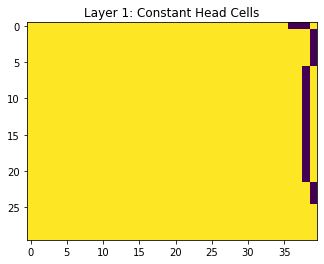

In [129]:
# vizualize the BC cells
iper = 0
ra = chd.stress_period_data.get_data(key=iper)

ibd = np.ones((nlay, nrow, ncol), dtype=np.int)
for k, i, j in ra['cellid']:
    ibd[k, i, j] = -1

ilay = 0
plt.imshow(ibd[ilay, :, :], interpolation='none')
plt.title('Layer {}: Constant Head Cells'.format(ilay + 1))

In [130]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model dis_test...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package oc...
    writing package chd...


In [131]:
sim.run_simulation()

FloPy is using the following  executable to run the model: ../../exe/mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.0.4 03/13/2019

   MODFLOW 6 compiled Mar 21 2019 15:37:31 with IFORT compiler (ver. 19.0.0)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Soft

(True, [])

In [132]:
# retrieve heads using a function
head=get_heads(model_name,model_dir)

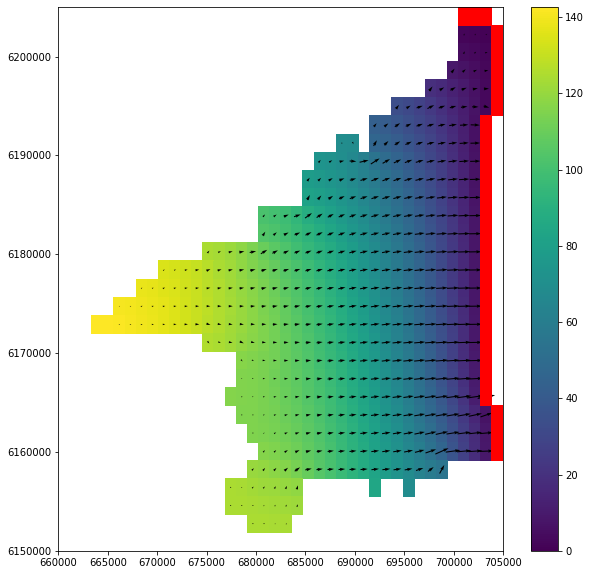

In [134]:
# make a plot

fig = plt.figure(figsize=(10,10))
ax  = plt.subplot(1, 1, 1, aspect='equal')
ml = fp.plot.PlotMapView(model=gwf)

#hmesh=ml.plot_ibound()
hmesh=ml.plot_array(head,masked_values=[1e30],cmap="viridis")
ml.plot_specific_discharge(spdis[0])
ml.plot_bc("chd",color="r")
plt.colorbar(hmesh)

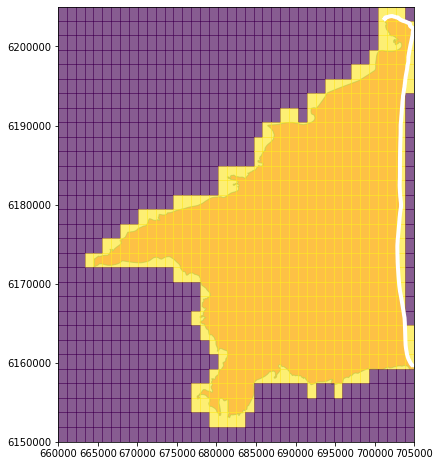

In [135]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(aspect='equal')

mm = fp.plot.PlotMapView(model=gwf)
#mm.plot_grid()
fp.plot.plot_shapefile(R_path,ax=ax,facecolor="Red",alpha=0.5)
mm.plot_array(dis.idomain.array,alpha=0.4)

fp.plot.plot_shapefile(BC_path,ax=ax,edgecolor="w",facecolor="none",linewidth=4)